# Loading and preprocessing your own data

In this tutorial, we demonstrate how to process your own dataset for later analysis on Google Colab.

We review the following steps:

1. Loading your own data  
2. Filtering
3. Normalization
4. Transformation

## 0. Introducing `scprep`

`scprep` is a lightweight scRNA-seq toolkit for Python Data Scientists.

Most scRNA-seq toolkits are written in R (the most famous being [Seurat](https://satijalab.org/seurat/)), but we (and a majority of machine learning / data scientists) develop our tools in Python. Currently, [Scanpy](https://icb-scanpy.readthedocs-hosted.com/en/stable/) is the most popular toolkit for scRNA-seq analysis in Python. However, Scanpy has a highly structured framework for data representation that is incompatible with the bulk of the Python data science framework, e.g. [pandas](https://pandas.pydata.org/), [SciPy](https://www.scipy.org/), and [scikit-learn](https://scikit-learn.org/stable/).

To accommodate users of the wider Python data analysis ecosystem, we developed `scprep` (<b>s</b>ingle <b>c</b>ell <b>prep</b>aration). `scprep` makes it easier to use the pandas / SciPy / scikit-learn ecosystem for scRNA-seq analysis. Most of `scprep` is composed of helper functions to perform tasks common to single cell data like loading counts matrices, filtering & normalizing cells by library size, and calculating common statistics. The key advantage of `scprep` is that data can be stored in Pandas DataFrames, NumPy arrays, Scipy sparse matrices, and no matter which tools you choose to interface with, _it just works_.

To learn more about `scprep`, you can read the documentation at https://scprep.readthedocs.io/.

## 1. Install tools

To run this notebook, you need to download a couple of packages. Unfortunately, due to restrictions of Google CoLab, these installations won't be saved. A workaround can be found at the following link if you're interested: https://stackoverflow.com/questions/52582858/saving-pip-installs-in-google-colab

For now, simply run the following line of code by clicking on the code cell and hit `Shift` + `Enter`.

**Once the installation has finished** (you should see `Succcessfully installed ...` on the last line), go to `Runtime -> Restart Runtime` from the menubar at the top of the page.

After restarting, there's no need to run the `!pip install` block again.



In [5]:
!pip install --user scprep tasklogger

     |████████████████████████████████| 102kB 2.3MB/s 


<a id='loading'></a>
## 2. Loading your own data

To run the tutorials with your own data, we will upload it to Google Colab and apply the preprocessing once. Then you can upload your processed data in each notebook instead of using the provided dataset.

First, open the "Files" sidebar, which you can open by clicking on the folder icon in the top right of the notebook.

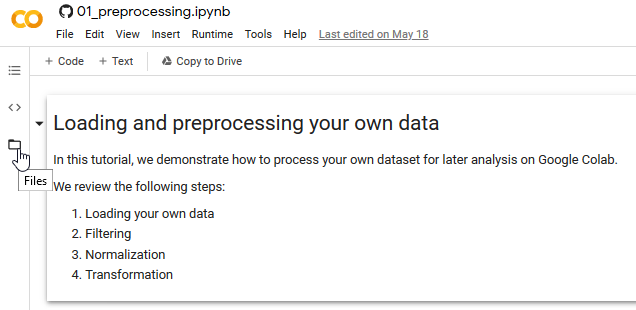

Next, click the "Upload" button and select all of the files you need--both data and metadata.

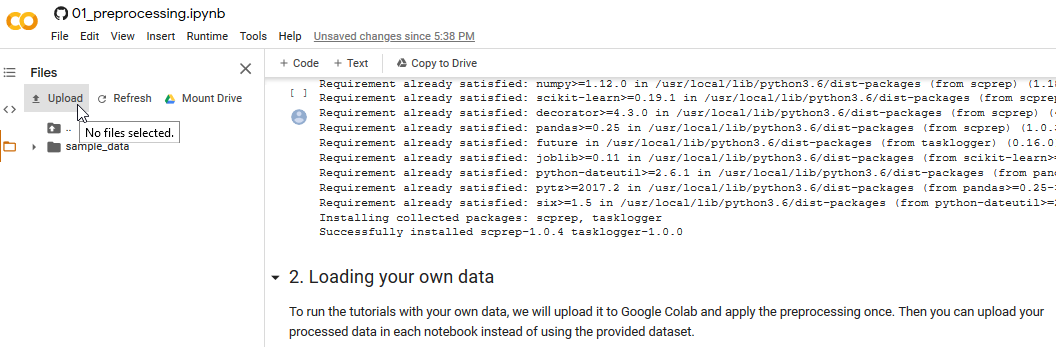

Once the upload is complete, we can read and preprocess the data.

### Using `scprep` to import data into Pandas DataFrames


We use a toolkit for loading and manipulating single-cell data called `scprep`. The functions in [`scprep.io`](https://scprep.readthedocs.io/en/stable/reference.html#module-scprep.io) will automatically load most single-cell datasets into a Pandas DataFrame. DataFrames are incredibly useful tools for data analysis in Python. To learn more about them, [check out the Pandas Documentation and Tutorials](https://pandas.pydata.org/pandas-docs/stable/).


Let's load the data and create a single matrix that we can use for preprocessing, visualization, and analysis.

In [0]:
import scprep

#### Loading 10X data (zipped folder)

Typically, 10X count matrices are stored in a folder containing `matrix.mtx.gz`, `features.tsv.gz` and `barcodes.tsv.gz`. To upload these to Google Colab, you will need to compress these three files (add them to a `.zip` archive) and upload the zipped folder. It does not need to be decompressed to load it with `scprep`.


In [0]:
data = scprep.io.load_10X_zip(filename)
data.head()

#### Loading 10X data (HDF5)

Sometimes, 10X count matrices are stored in a HDF5 (or H5) file, a hierarchical file structure with native compression. You can upload and read this file directly.

In [0]:
data = scprep.io.load_10X_HDF5(filename)
data.head()

#### Loading text data (csv/tsv/txt)

Most other data formats are text-based, meaning the gene expression values are stored in plain text separated by a special character, usually a comma or a tab. You may also see a compressed version of these (most often `.csv.gz`), which do not need to be decompressed before loading with `scprep`.

In [0]:
data = scprep.io.load_csv(filename, cell_axis='row', sparse=True)
# or, if your data is tab-spaced
# data = scprep.io.load_tsv(filename, cell_axis='row', sparse=True)
data.head()

Your data should have cell barcodes on the rows and genes on the columns. If you see the opposite of this, you should switch the `cell_axis` argument in the data loading function call and run it again.

#### Loading other data

If your data is not of any of the above formats, please feel free to ask for help in how to load it.

### Dealing with multiple data files

More complex single-cell datasets will often involve more than one file, for example in time-course experiments. In this case, we will combine each of the datasets in a list. Give the first data file we uploaded an appropriate batch name in the cell below.

If you only have one data file, skip to section 2.1.

In [0]:
# =============
# Give your first batch an appropriate name
first_batch_label = # Fill in the batch name, e.g. "Control"
# =============

data = [data]
batch_labels = [first_batch_label]

Run the cell below once for every file in your dataset, changing the batch name each time.

In [0]:
# =============
# Load your data with the appropriate `io` function
next_data = scprep.io. # fill in the load function, e.g. scprep.io.load_10X_zip(filename)
next_batch_label = # fill in the batch name, e.g. "Mutant"
# =============

data.append(next_data)
batch_labels.append(next_batch_label)

Now, we can combine our datasets into a single combined data matrix. If you wish, you may first apply library size filtering to each batch individually, as described in section 2.3, but this is not strictly necessary.

In [0]:
data, sample_labels = scprep.utils.combine_batches(data, batch_labels)

### 2.1. Standard imports

We'll import these few packages at the beginning of nearly every session.

In [0]:
import pandas as pd
import numpy as np
import scprep

import matplotlib.pyplot as plt

# matplotlib settings for Jupyter notebooks only
%matplotlib inline

#### Understanding the data matrix

How big is our matrix? We can find out with `data.shape`.

In [0]:
data.shape

Most Python data analysis techniques handle a single data matrix with rows (cells) and columns (genes). In Pandas DataFrames, each row and column has a name associated with it.

The _columns_ refer to the genes, of features of the data. `data.columns` gives these as a list.

In [0]:
data.columns

The _rows_ refer to the cells, of observations of the data. `data.index` gives these as a list.

In [0]:
data.index

Note that some tools expect the opposite: that genes would be on the rows and cells on the columns. This is a hold-over from bulk RNA-seq, when it made sense for each replicate (of which there were few) to be a feature and each gene (of which there were many) to be an observation; however, now that we can have as many or more cells than genes, it makes more sense for cells to be observations. Keep this difference in mind when you try new tools.

Finally, we can view the actual matrix, either by simply typing the matrix name to view the whole thing, or using the `.head()` function to view the first few rows.

In [0]:
data.head(10)

### 2.2 Creating the metadata matrix

Often, there is additional information associated with our cells which we want to retain (e.g. batch, library size, cluster number, etc.) Here we create a metadata DataFrame to store this information.

In [0]:
metadata = pd.DataFrame(index = data.index)

If you combined multiple datasets to create your data matrix, we can add the sample labels to the metadata.

In [0]:
metadata['sample_labels'] = sample_labels

### 2.3. Library size filtering

#### Why we filter cells by library size
In scRNA-seq the library size of a cell is the number of unique mRNA molecules detected in that cell. These unique molecules are identified using a random barcode incorporated during the first round of reverse transcription. This barcode is called a <b>U</b>nique <b>M</b>olecule <b>I</b>dentifier, and often we refer to the number unique mRNAs in a cell as the number of UMIs. To read more about UMIs, [Smith *et al.* (2017)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5340976/) write about how sequencing errors and PCR amplification errors lead to innaccurate quantification of UMIs/cell.

Depending on the method of scRNA-seq, the amount of library size filtering done can vary. The 10X Genomics CellRanger tool, the DropSeq and InDrops pipelines, and the Umitools package each have their own method and cutoff for determining real cells from empty droplets. Additional methods exist for trying to detect the difference between droplets containing one cell and droplets containing two cells ("doublets"). You can take these methods at face value or set some manual cutoffs based on your data.

#### Visualing the library size distribution using `scprep`

There is a helper function for plotting library size from a gene expression matrix in scprep called [`scprep.plot.plot_library_size()`](https://scprep.readthedocs.io/en/stable/reference.html#scprep.plot.plot_library_size).

Let's have a look at the library size for the first time point. In this sample we see that there is a small number of cells with very small library sizes and a long tail of cells that have very high library sizes.

In [0]:
scprep.plot.plot_library_size(data,
                              log=False, title='Library Size Before Filtering')

Choose cutoffs above and below the main bulk of cells, removing cells that are both significantly smaller than average and significantly larger than average. You can plot the result by running `scprep.plot.plot_library_size` with `cutoff=(low, high)` or `percentile=(low, high)` where low and high are values or percentiles that you choose.

In [0]:
# =============
# Select appropriate percentiles (percentile=(low, high))
# for filtering and plot the result
scprep.plot.plot_library_size( # e.g., scprep.plot.plot_library_size(data, percentile=(20, 90))
# =============

#### Selecting a cutoff

Several papers describe strategies for picking a maximum and minimum threshold that can be found with a quick google search for "library size threshold single cell RNA seq".

Most of these pick an arbitrary measure such as a certain number of deviations below or above the mean or median library size. We find that spending too much time worrying about the exact threshold is inefficient, as results tend to be robust to filtering beyond some minimum threshold.

For the above dataset, I would remove all cells with more than 12,000 UMI / cell in fear they might represent doublets of cells. I will generally also remove all cells with fewer than 1000 reads per cell.

### Exercise 1 - Filtering cells by library size

You can do this using [`scprep.filter.filter_library_size()`](https://scprep.readthedocs.io/en/stable/reference.html#scprep.filter.filter_library_size).

In [0]:
# ==================
# fill in your chosen `percentile` values
percentiles = # e.g. (20, 90)
data, metadata = scprep.filter.filter_library_size(data, metadata, percentile=percentiles)
# ==================

In [0]:
scprep.plot.plot_library_size(data, log=False, title='Library size after filtering')

The library size distribution is now much more constrained, which will reduce the effects of differences in library size (which can affect your results, even after normalization).

### 2.4 Subsampling data

Finally, because the Google Colab client is not the most powerful client, we'll subsample this dataset to allow you to run the preprocessing steps a little more quickly.

In [0]:
data, metadata = scprep.select.subsample(data, metadata, n=10000)

In [0]:
data.shape, metadata.shape

#### Batch effects

It's worth noting here that if you have combined different experiments into one data matrix here, you are potentially exposed yourself to a "batch effect". A batch effect is a difference (technical or biological) between two batches of an experiment. This can be caused by systematic error (e.g. a difference in temperature during library preparation) or a genuine biological effect of interest (e.g. in this case each batch is sampled at a different time of development.)

Correcting for technical / systematic batch effects is a topic will we cover in detail later in the workshop; however it's worth noting that any time we combine multiple experiments, we should check to see if they are substantially different and compare this to our expectations. If the effect is large and unexpected, we can either a) attempt to correct it / account for it using computational methods, or b) modify our analysis to avoid combining the datasets.

<a id='preprocessing'></a>
## 3. Preprocessing: Filtering, Normalizing, and Transforming

### Filtering

We filter the data by: 
1. Removing dead cells  
2. Filtering by library size (if we did not do this prior to combining batches)
3. Removing genes that are expressed in relatively few cells.

### 3.1 Dead cell removal

#### What does high mitochondrial gene expression indicate?

Generally, we assume that cells with high detection of mitochondrial RNAs have undergone degradation of the mitochondrial membrane as a result of apoptosis. This may be from stress during dissociation, culture, or really anywhere in the experimental pipeline. As with the high and low library size cells, we want to remove the long tail from the distribution. In a successful experiment, it's typical for 5-10% of the cells to have this apoptotic signature.

#### Plotting mitochondrial expression

Let's look at the mitochondrial expression. You can do this using [`scprep.plot.plot_gene_set_expression()`](https://scprep.readthedocs.io/en/stable/reference.html#scprep.plot.plot_gene_set_expression), which conveniently gets you the list of mitochrondrial genes by name using the helper function [`scprep.select.get_gene_set()`](https://scprep.readthedocs.io/en/stable/reference.html#scprep.select.get_gene_set).

In [0]:
# Plot all mitochondrial genes. There are 14, FYI.
scprep.plot.plot_gene_set_expression(data, starts_with="MT-",
                                     library_size_normalize=True,
                                     title="Mitochrondrial expression before filtering")

Here we see that above some threshold, there is a steep increase in expression of mitochondrial RNAs. We'll remove these cells from further analysis. Choose a cut-off based on the histogram above and plot your chosen value on a new histogram.

### Exercise 2 - filtering dead cells by mitochondrial expression

In [0]:
# ================
# choose a cutoff at which to plot a red line such that you
# remove cells with aberrant mitochondrial expression
scprep.plot.plot_gene_set_expression(
    data, starts_with="MT-",
    library_size_normalize=True,
    cutoff = 
)
# ================

Now we can remove those cells.

In [0]:
# ================
# Fill in your chosen cutoff value
cutoff = 
# ================
data, metadata = scprep.filter.filter_gene_set_expression(
    data, metadata, starts_with="MT-",
    cutoff=cutoff, keep_cells='below', library_size_normalize=True)
data.shape

Let's look at that histogram again.

In [0]:
scprep.plot.plot_gene_set_expression(data, starts_with="MT-",
                                     library_size_normalize=True,
                                     title="Mitochrondrial expression after filtering")

Much better! We have a tight distribution without a long tail, indicating that all of our cells have relatively normal mitochondrial expression.

### 3.2 - Filtering lowly expressed genes

#### Why remove lowly expressed genes?

Capturing RNA from single cells is a noisy process. The first round of reverse transcription is done in the presence of cell lysate. This results in capture of only 10-40% of the mRNA molecules in a cell leading to a phenomenon called dropout where some lowly expressed genes are not detected in cells in which they are expressed [[1](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5561556/#CR13), [2](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5561556/#CR44), [3](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5561556/#CR64), [4](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5561556/#CR65)]. As a result, some genes are so lowly expressed (or expressed not at all) that we do not have sufficient observations of that gene to make any inferences on its expression.

Lowly expressed genes that may only be represented by a handful of mRNAs may not appear in a given dataset. Others might only be present in a small number of cells. Because we lack sufficient information about these genes, we remove lowly expressed genes from the gene expression matrix during preprocessing. Typically, if a gene is detected in fewer than very few cells, it gets removed.

Here, we can see that in EB dataset, there are many genes that are detected in very few cells.

In [0]:
scprep.plot.histogram(scprep.measure.gene_capture_count(data), log=True,
                      title="Gene capture before filtering",
                     xlabel='# of cells with nonzero expression',
                     ylabel='# of genes')

Again, we see a relatively clean distribution on the right (genes observed in many cells) with a heavy tail on the right (rare genes). Where would you choose to cut this off?

### Exercise 3 - filtering rare genes

In [0]:
# ================
# choose a cutoff
scprep.plot.histogram(scprep.measure.gene_capture_count(data), 
                      cutoff =
                      log=True,
                      title="Gene capture before filtering",
                     xlabel='# of cells with nonzero expression',
                     ylabel='# of genes')
# ================

Let's go ahead and remove those genes.

In [0]:
# ================
# choose a cutoff
cutoff = 
data = scprep.filter.filter_rare_genes(data, min_cells=cutoff)
# ================

We can plot the above histogram again for good measure. As you can see, the rare genes are all gone.

In [0]:
scprep.plot.histogram(scprep.measure.gene_capture_count(data), cutoff=cutoff, log=True,
                      title="Gene capture after filtering",
                     xlabel='# of cells with nonzero expression',
                     ylabel='# of genes')

In [0]:
data.shape

After filtering, we have removed many thousands of genes. This will be our last filtering step, though you can always filter out aberrant expression on an ad hoc basis. As it stands, we've quite significantly reduced our dataset from 10,000 x 33,000 that we started with. And that's not even counting the cells we removed by library size before combining time points!

### 3.3 - Normalization

As you saw during filtering, the range of library sizes between cells can be quite extreme. We visualized this for one time point pre-filtering, but let's now visualize the whole dataset, post-filtering.

In [0]:
scprep.plot.plot_library_size(data, title='Library size before normalization')

To correct for differences in library sizes, we divide each cell by its library size and then rescale by the a fixed value, sometimes the median library size. The default in `scprep` is to rescale every cell to 10,000 counts to make numbers comparable across datasets.

In python this is performed using the preprocessing method [`scprep.normalize.library_size_normalize()`](https://scprep.readthedocs.io/en/stable/reference.html#scprep.normalize.library_size_normalize).

In [0]:
data, metadata['library_size'] = scprep.normalize.library_size_normalize(data, return_library_size=True)

If you plot the library sizes again, you'll see they are all the same.

In [0]:
scprep.plot.plot_library_size(data, title='Library size after normalization')

### 3.4 - Gene Count Transformation

In scRNA-seq analysis, we often see that some genes are orders of magnitude more common than others. Let's have a look at the mean expression of each gene.

In [0]:
scprep.plot.histogram(data.mean(axis=0), log='y',
                      title="Gene counts before transformation",
                     xlabel='total # of gene counts',
                     ylabel='# of genes')

In order to avoid these high-expression genes dominating the variation, the data is often $\log$-transformed. This typically requires the addition of some small value to avoid taking $\log(0)$. We avoid this issue entirely by instead taking the square root transform. The square root function has a similar form as the $\log$ function with the added benefit of being stable at 0.

In [0]:
data = scprep.transform.sqrt(data)

After transformation, you should see that the mean expression values are now much closer together.

In [0]:
scprep.plot.histogram(data.mean(axis=0), log='y',
                      title="Gene counts after transformation",
                     xlabel='total # of gene counts',
                     ylabel='# of genes')

### 4.0 Saving the output

There are many ways to save a Pandas DataFrame, including built in `pandas` function [`DataFrame.to_csv`](https://pandas.pydata.org/pandas-docs/stable/user_guide/io.html#writing-out-data) and `scprep` function [`scprep.io.save_mtx`](https://scprep.readthedocs.io/en/stable/reference.html#scprep.io.save_mtx). For speed, we will be using [`DataFrame.to_pickle`](https://pandas.pydata.org/pandas-docs/stable/user_guide/io.html#pickling) which is extremely fast and efficient for reading and writing matrices in Python.

The next cell will write the processed data matrices to disk.

In [0]:
data.to_pickle("data.pickle.gz")
metadata.to_pickle("metadata.pickle.gz")

To see the new files in the Files pane, click "Refresh".

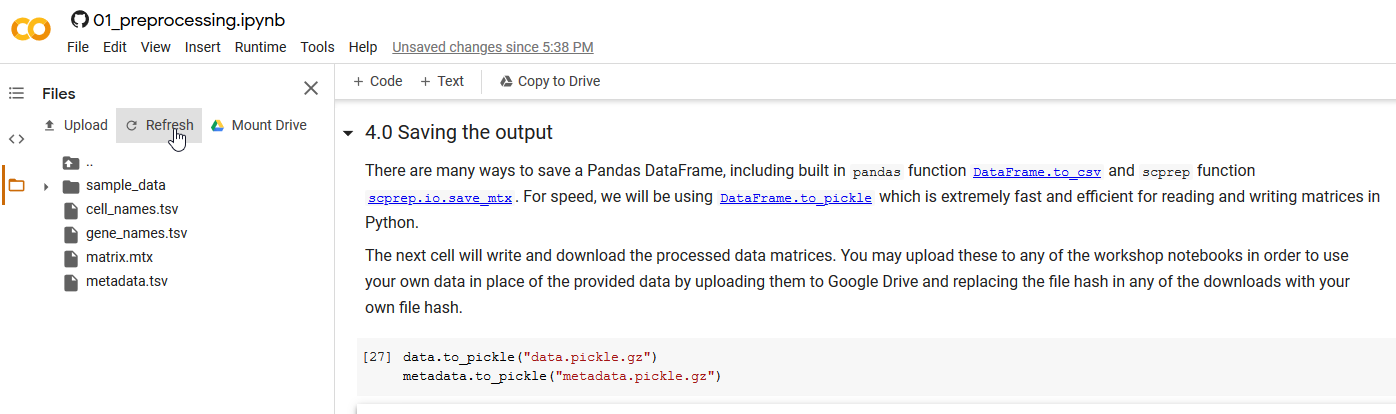

Click the three dots on `data.pickle` and select "Download". It may take a while to prepare the download. Repeat for `metadata.pickle`.

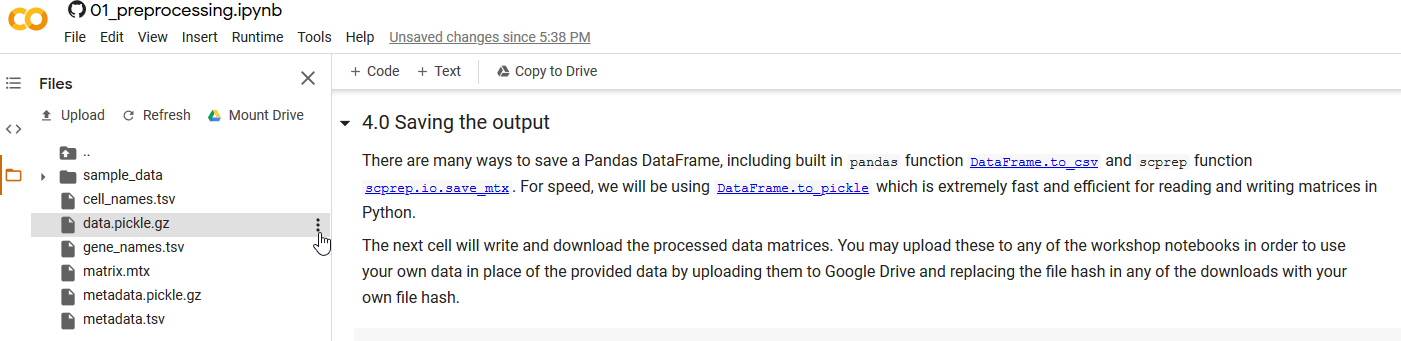

You may upload these to any of the workshop notebooks in order to use your own data in place of the provided data by uploading them to [Google Drive](https://drive.google.com) and replacing the file hash in any of the downloads with your own file hash.

Upload the files to Google Drive by dragging the files you downloaded into the Google Drive browser window.

To find the file hash for your uploaded files, right click on the file and click "Get Shareable Link". 

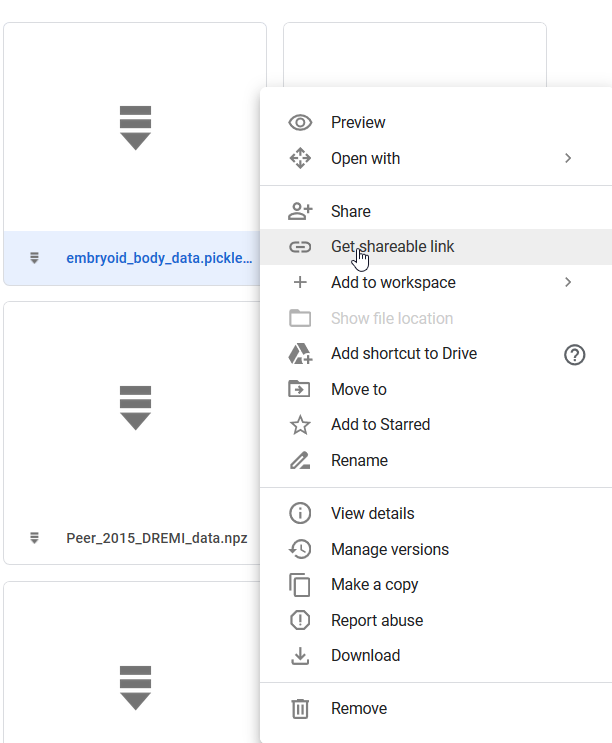

You should see something like this:
```
https://drive.google.com/open?id=1Xz0ONnRWp2MLC_R6r74MzNwaZ4DkQPcM
```
or like this:
```
https://drive.google.com/file/d/1Xz0ONnRWp2MLC_R6r74MzNwaZ4DkQPcM/view?usp=sharing
```
Either way, what we're looking for is that string of random letters and numbers, either between **`id=`** and the end, or between **`/d/`** and **`/view`**. In this case, the hash is `1Xz0ONnRWp2MLC_R6r74MzNwaZ4DkQPcM`.

Once we have the hash, we can download the file using [`scprep.io.download.download_google_drive`](https://scprep.readthedocs.io/en/stable/reference.html#scprep.io.download.download_google_drive).

In [5]:
scprep.io.download.download_google_drive("1Xz0ONnRWp2MLC_R6r74MzNwaZ4DkQPcM", "data.pickle.gz")
pd.read_pickle("data.pickle.gz")

,FO538757.2 (ENSG00000279457),AP006222.2 (ENSG00000228463),RP11-206L10.9 (ENSG00000237491),LINC00115 (ENSG00000225880),FAM41C (ENSG00000230368),RP11-54O7.1 (ENSG00000230699),RP11-54O7.2 (ENSG00000241180),RP11-54O7.3 (ENSG00000223764),SAMD11 (ENSG00000187634),NOC2L (ENSG00000188976),...,MT-ND4L (ENSG00000212907),MT-ND4 (ENSG00000198886),MT-ND5 (ENSG00000198786),MT-ND6 (ENSG00000198695),MT-CYB (ENSG00000198727),AC011043.1 (ENSG00000276256),AL592183.1 (ENSG00000273748),AC007325.4 (ENSG00000278817),AC004556.1 (ENSG00000276345),AC240274.1 (ENSG00000271254)
AAACCGTGCAGAAA-1_Day 00-03,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,3.288398,1.898557,0.000000,3.797115,0.0,0.0,0.000000,0.0,0.0
AAACGCACCGGTAT-1_Day 00-03,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.931534,...,0.0,3.158984,1.140891,0.658694,3.293468,0.0,0.0,0.000000,0.0,0.0
AAACGCACCTATTC-1_Day 00-03,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,3.282188,1.432464,0.000000,4.237287,0.0,0.0,0.000000,0.0,0.0
AAAGATCTCTGCTC-1_Day 00-03,0.0,1.232158,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,3.141399,0.871267,0.000000,4.086606,0.0,0.0,0.000000,0.0,0.0
AAAGATCTGGTACT-1_Day 00-03,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.686594,...,0.0,2.912970,0.970990,0.000000,3.760628,0.0,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTCGAACTTCTCA-1_Day 24-27,0.0,1.792619,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,1.267573,0.000000,4.391002,0.0,0.0,1.267573,0.0,0.0
TTTCTACTCTTATC-1_Day 24-27,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,3.677589,1.300224,1.300224,2.600448,0.0,0.0,0.000000,0.0,0.0
TTTCTACTTGAGCT-1_Day 24-27,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,1.334102,0.0,0.0,0.000000,0.0,0.0
TTTGCATGATGACC-1_Day 24-27,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,4.547889,0.000000,2.033878,2.033878,0.0,0.0,0.000000,0.0,0.0


## Summary

To summarize, we've preprocessed our data as follows:

1. Filter by library size to remove empty droplets and doublets
2. Combine batches
3. Filter out rarely expressed genes
4. Filter cells with high mitochrondrial expression
5. Normalize by library size
6. Square root transform
7. Save and download